In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score, precision_score

In [4]:
X_train = pd.read_csv('data/X_train.csv')
X_test = pd.read_csv('data/X_test.csv')

# We use .ravel() to flatten the target arrays y and to avoid warnings
y_train = pd.read_csv('data/y_train.csv').values.ravel()
y_test = pd.read_csv('data/y_test.csv').values.ravel()

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape:     {X_test.shape}")

Training set shape: (1037340, 24)
Test set shape:     (259335, 24)


In [10]:
# We use dummy model that always predicts the majority class (here the nonfraud), so we will have a really good precision normally but bad recall
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

# Predictions
y_pred_dummy = dummy.predict(X_test)

# Evaluation
print("\nBaseline Results")
# We use zero_division=0 to avoid warning because we devide by 0
print(classification_report(y_test, y_pred_dummy, digits=4, zero_division=0))


Baseline Results
              precision    recall  f1-score   support

           0     0.9942    1.0000    0.9971    257834
           1     0.0000    0.0000    0.0000      1501

    accuracy                         0.9942    259335
   macro avg     0.4971    0.5000    0.4985    259335
weighted avg     0.9885    0.9942    0.9913    259335



Before implementing complex Machine Learning algorithms, it is essential to establish a baseline performance. This serves as a reference point to evaluate whether our future models are actually learning patterns or just guessing.

Our dataset is highly imbalanced (1 fraud for every ~170 legitimate transactions).
If a model simply predicts No Fraud for every single transaction, it will achieve an Accuracy of 99.42%.

This kind of model is useless for our business objective, which is detecting fraud.
So, we must beat this baseline, specifically by improving the Recall and F1-Score for the minority class (Fraud), even if it means loosing a bit of overall accuracy.


Standard LogReg Results
              precision    recall  f1-score   support

           0     0.9942    1.0000    0.9971    257834
           1     0.0000    0.0000    0.0000      1501

    accuracy                         0.9942    259335
   macro avg     0.4971    0.5000    0.4985    259335
weighted avg     0.9885    0.9942    0.9913    259335



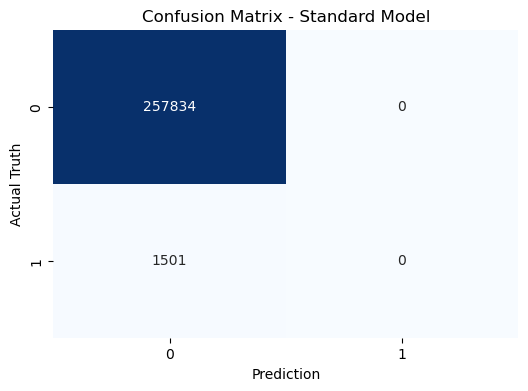

In [17]:
# Here we will try a standard model without handling class imbalance
lr_std = LogisticRegression(max_iter=1000, random_state=42)
lr_std.fit(X_train, y_train)

# Predictions
y_pred_std = lr_std.predict(X_test)

# Evaluation
print("\nStandard LogReg Results")
print(classification_report(y_test, y_pred_std, digits=4, zero_division=0))

# Visualization
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_std), annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - Standard Model')
plt.ylabel('Actual Truth')
plt.xlabel('Prediction')
plt.show()

Despite analyzing the features, the Standard Logistic Regression yields the same result as the naive baseline (0 fraud detected).
Due to the severe class imbalance, the algorithm determines that predicting No Fraud for every transaction is the most effective way to maximize overall Accuracy, effectively ignoring the minority class.

In [24]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# We create a Pipeline, we standardise and next try the Log Reg
model_balanced = make_pipeline(StandardScaler(), LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
model_balanced.fit(X_train, y_train)

# Prédictions
y_pred_bal = model_balanced.predict(X_test)

print("\nResults LogReg Balanced")
print(classification_report(y_test, y_pred_bal, digits=4))


Results LogReg Balanced
              precision    recall  f1-score   support

           0     0.9984    0.8808    0.9359    257834
           1     0.0357    0.7588    0.0682      1501

    accuracy                         0.8801    259335
   macro avg     0.5171    0.8198    0.5021    259335
weighted avg     0.9928    0.8801    0.9309    259335



We here tried to use a pipeline with StandardScaler and class_weight=balanced to try to increase the recall and it worked, we obtained 75.88% recall on the fraud class.
